In [3]:
from wavkan.KAN import KAN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv('../data/multi_class_resampled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059274 entries, 0 to 2059273
Data columns (total 71 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [5]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,8080,1025246,3,3,0,18,0,0,0.00,0.000000,...,28,0.0,0.0,0,0,0.0,0.0,0,0,9
1,8080,1045102,3,3,0,18,0,0,0.00,0.000000,...,28,0.0,0.0,0,0,0.0,0.0,0,0,9
2,8080,1001817,3,3,0,18,0,0,0.00,0.000000,...,28,0.0,0.0,0,0,0.0,0.0,0,0,9
3,8080,61529,4,3,207,134,195,0,51.75,95.541876,...,20,0.0,0.0,0,0,0.0,0.0,0,0,9
4,51740,18,1,1,6,6,6,6,6.00,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,9


In [6]:
X_train=df.drop(columns=[' Label'])
y_train=df[' Label']
print(X_train.shape)
print(y_train.shape)
test_set=pd.read_csv('../data/multi_test.csv')
X_test=test_set.drop(columns=[' Label'])
y_test=test_set[' Label']
print(X_test.shape)
print(y_test.shape)

(2059274, 70)
(2059274,)
(71857, 70)
(71857,)


In [7]:
# all
features=['Flow Bytes/s', ' Fwd Packet Length Min', ' Idle Std', ' Bwd Packets/s', 'FIN Flag Count', ' Active Std', ' Down/Up Ratio', ' Init_Win_bytes_backward', ' Active Min', 'Bwd IAT Total', 'Init_Win_bytes_forward', ' SYN Flag Count', 'Fwd PSH Flags', 'Fwd Packets/s', ' Flow Packets/s', ' URG Flag Count', ' Bwd Packet Length Min', ' PSH Flag Count', ' Flow IAT Min', ' Bwd IAT Std', ' Active Max', ' Min Packet Length', ' Subflow Fwd Bytes', 'Total Length of Fwd Packets', 'Fwd IAT Total', ' Flow Duration', 'Active Mean', ' Destination Port', ' Fwd Packet Length Std', ' Bwd IAT Max', ' Bwd IAT Min', ' ACK Flag Count', ' Idle Min', ' Bwd IAT Mean', ' Flow IAT Mean', ' Packet Length Variance', ' Fwd Packet Length Max', ' Fwd IAT Min', ' Avg Fwd Segment Size', ' Fwd Packet Length Mean', 'Idle Mean', ' Fwd IAT Std', ' Fwd URG Flags', ' CWE Flag Count', ' RST Flag Count', ' ECE Flag Count', ' Idle Max', ' Bwd Header Length', ' Flow IAT Max', ' Fwd IAT Max', ' Flow IAT Std', ' Fwd IAT Mean', ' Bwd Packet Length Std', ' Average Packet Size', ' Packet Length Mean', 'Bwd Packet Length Max', ' Packet Length Std', ' Fwd Header Length.1', ' Fwd Header Length', ' Avg Bwd Segment Size', ' Bwd Packet Length Mean', ' Max Packet Length', ' min_seg_size_forward', ' Total Length of Bwd Packets', ' Subflow Bwd Bytes', ' Subflow Bwd Packets', ' Total Backward Packets', ' Total Fwd Packets', 'Subflow Fwd Packets', ' act_data_pkt_fwd']
# rf
# features=[' Bwd Packet Length Std', ' Bwd Packet Length Mean', ' Packet Length Variance', ' Average Packet Size', ' Max Packet Length', ' Avg Bwd Segment Size', ' Total Length of Bwd Packets', ' Packet Length Mean', ' Packet Length Std', 'Bwd Packet Length Max', ' Destination Port', 'Subflow Fwd Packets', ' Subflow Bwd Bytes', ' Total Fwd Packets', 'Total Length of Fwd Packets', ' Subflow Fwd Bytes', ' min_seg_size_forward', ' PSH Flag Count', ' Fwd Packet Length Max', ' act_data_pkt_fwd', ' ACK Flag Count', ' Bwd Header Length', ' Flow IAT Std', ' Avg Fwd Segment Size', ' Fwd Packet Length Mean', ' Fwd Header Length.1', ' Flow IAT Max', ' Total Backward Packets', ' Bwd Packets/s', ' Init_Win_bytes_backward', 'Fwd IAT Total', ' Fwd IAT Min', 'Init_Win_bytes_forward', ' Flow IAT Mean', ' Fwd Header Length', ' Subflow Bwd Packets', ' Idle Min', ' Fwd IAT Std', 'Flow Bytes/s', ' Flow Packets/s']
# pca
# features=['Flow Bytes/s', ' Fwd Packet Length Min', ' Idle Std', ' Bwd Packets/s', 'FIN Flag Count', ' Active Std', ' Down/Up Ratio', ' Init_Win_bytes_backward', ' Active Min', 'Bwd IAT Total', 'Init_Win_bytes_forward', ' SYN Flag Count', 'Fwd PSH Flags', 'Fwd Packets/s', ' Flow Packets/s', ' URG Flag Count', ' Bwd Packet Length Min', ' PSH Flag Count', ' Flow IAT Min', ' Bwd IAT Std', ' Active Max', ' Min Packet Length', ' Subflow Fwd Bytes', 'Total Length of Fwd Packets', 'Fwd IAT Total', ' Flow Duration', 'Active Mean', ' Destination Port', ' Fwd Packet Length Std', ' Bwd IAT Max', ' Bwd IAT Min', ' ACK Flag Count', ' Idle Min', ' Bwd IAT Mean', ' Flow IAT Mean', ' Packet Length Variance', ' Fwd Packet Length Max', ' Fwd IAT Min', ' Avg Fwd Segment Size', ' Fwd Packet Length Mean', 'Idle Mean', ' Fwd IAT Std', ' Fwd URG Flags', ' CWE Flag Count', ' RST Flag Count', ' ECE Flag Count', ' Idle Max', ' Bwd Header Length', ' Flow IAT Max', ' Fwd IAT Max', ' Flow IAT Std', ' Fwd IAT Mean', ' Bwd Packet Length Std', ' Average Packet Size', ' Packet Length Mean', 'Bwd Packet Length Max', ' Packet Length Std', ' Fwd Header Length.1', ' Fwd Header Length', ' Avg Bwd Segment Size', ' Bwd Packet Length Mean', ' Max Packet Length', ' min_seg_size_forward', ' Total Length of Bwd Packets', ' Subflow Bwd Bytes', ' Subflow Bwd Packets', ' Total Backward Packets', ' Total Fwd Packets', 'Subflow Fwd Packets', ' act_data_pkt_fwd'][:30]
# dt
# features=[' Bwd Packet Length Std', ' Average Packet Size', ' Max Packet Length', ' Destination Port', ' Total Length of Bwd Packets', ' Init_Win_bytes_backward', ' Bwd Packets/s', ' Bwd IAT Std', ' Subflow Bwd Bytes', ' Bwd IAT Min', 'Subflow Fwd Packets', ' Fwd Packet Length Std', ' Fwd Packet Length Max', ' Fwd IAT Std', ' Fwd IAT Mean', ' Flow IAT Min', ' Total Fwd Packets', ' Flow Duration', 'Total Length of Fwd Packets', ' Total Backward Packets']
# scaler1=MinMaxScaler(feature_range=(-1, 1))
# X_train=scaler1.fit_transform(X_train[features])
# scaler2=MinMaxScaler(feature_range=(-1, 1))
# X_test=scaler2.fit_transform(X_test[features])
# scaler1=StandardScaler()
# X_train=scaler1.fit_transform(X_train)
# scaler2=StandardScaler()
# X_test=scaler2.fit_transform(X_test)
X_train=X_train[features].to_numpy()
X_test=X_test[features].to_numpy()

print("Original label range:", y_train.min(), "to", y_train.max())

# Shift labels to start from 0 instead of 1
y_train = y_train - 1
y_test = y_test - 1

# Verify the new range
print("Adjusted label range:", y_train.min(), "to", y_train.max())


Original label range: 1 to 14
Adjusted label range: 0 to 13


In [8]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 512  # Adjust based on your memory constraints
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Defining wavelet types to try
# wavelet_types = ['dog','mexican_hat', 'morlet', 'meyer', 'shannon']
wavelet_types = ['shannon', 'dog', 'morlet']

# Training parameters
trials = 1  # Reduced from 5 due to larger dataset
epochs_per_trial = 40  # Reduced from 50 due to larger dataset

In [11]:
# Metrics for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = [14, 10]

In [12]:
results = {}

# Looping over each wavelet type
for wavelet in wavelet_types:
    all_metrics = {
        'train_loss': [], 'train_acc': [], 'train_precision': [], 
        'train_recall': [], 'train_f1': [], 
        'val_loss': [], 'val_acc': [], 'val_precision': [], 
        'val_recall': [], 'val_f1': []
    }
    
    print(f'Testing wavelet: {wavelet}')
    
    for trial in range(trials):
        print(f'Trial {trial+1}/{trials}')
        best_val_loss = float('inf')
        patience = 5
        patience_counter = 0
        best_model_state = None
        
        # Define model for multiclass classification
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        num_classes = 14  # Store this as a variable for consistency
        model = KAN([len(features), 128, 32, num_classes], wavelet_type=wavelet, dropout_rate=0.0).to(device)
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs!")
            model = nn.DataParallel(model)
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2
        )
        criterion = nn.CrossEntropyLoss()
        
        trial_metrics = {key: [] for key in all_metrics.keys()}
        
        for epoch in range(epochs_per_trial):
            # Training
            model.train()
            train_loss = 0.0
            train_preds, train_targets = [], []
            
            for X_batch, y_batch in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs_per_trial}', leave=False):
                X_batch = X_batch.to(device)
                
                # Convert targets to proper format
                if y_batch.dim() > 1 and y_batch.shape[1] > 1:
                    y_batch = torch.argmax(y_batch, dim=1)
                
                y_batch = y_batch.to(device).long()
                
                # CRITICAL: Check for invalid target values
                # Target values should be in range [0, num_classes-1]
                min_target = y_batch.min().item()
                max_target = y_batch.max().item()
                
                if min_target < 0 or max_target >= num_classes:
                    print(f"ERROR: Invalid target values found! Range: [{min_target}, {max_target}]")
                    print(f"Target values should be in range [0, {num_classes-1}]")
                    # Try to fix the issue by clamping target values
                    y_batch = torch.clamp(y_batch, 0, num_classes-1)
                    print(f"Target values clamped to range [0, {num_classes-1}]")
                
                optimizer.zero_grad()
                outputs = model(X_batch)
                
                # More debugging info
                # print(f"Output shape: {outputs.shape}, Target shape: {y_batch.shape}")
                # print(f"Output type: {outputs.dtype}, Target type: {y_batch.dtype}")
                # print(f"Unique target values: {torch.unique(y_batch).tolist()}")
                
                try:
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    
                    # Get predicted class
                    _, predicted = torch.max(outputs.data, 1)
                    train_preds.extend(predicted.cpu().numpy())
                    train_targets.extend(y_batch.cpu().numpy())
                except RuntimeError as e:
                    print(f"Error in training batch: {e}")
                    print(f"Unique target values: {torch.unique(y_batch).tolist()}")
                    print(f"Output min/max: {outputs.min().item()}, {outputs.max().item()}")
                    # Skip this batch and continue
                    continue
            
            if len(train_preds) == 0:
                print("No valid batches processed in this epoch. Skipping...")
                continue
            
            # Calculate training metrics
            train_loss /= len(trainloader)
            train_acc = accuracy_score(train_targets, train_preds)
            train_precision = precision_score(train_targets, train_preds, zero_division=0, average='weighted')
            train_recall = recall_score(train_targets, train_preds, zero_division=0, average='weighted')
            train_f1 = f1_score(train_targets, train_preds, zero_division=0, average='weighted')
            
            trial_metrics['train_loss'].append(train_loss)
            trial_metrics['train_acc'].append(train_acc)
            trial_metrics['train_precision'].append(train_precision)
            trial_metrics['train_recall'].append(train_recall)
            trial_metrics['train_f1'].append(train_f1)
            
            # Validation
            model.eval()
            val_loss = 0.0
            val_preds, val_targets = [], []
            
            with torch.no_grad():
                for X_batch, y_batch in testloader:
                    X_batch = X_batch.to(device)
                    
                    if y_batch.dim() > 1 and y_batch.shape[1] > 1:
                        y_batch = torch.argmax(y_batch, dim=1)
                    
                    y_batch = y_batch.to(device).long()
                    
                    # Same check for validation data
                    if y_batch.min().item() < 0 or y_batch.max().item() >= num_classes:
                        y_batch = torch.clamp(y_batch, 0, num_classes-1)
                    
                    try:
                        outputs = model(X_batch)
                        loss = criterion(outputs, y_batch)
                        val_loss += loss.item()
                        
                        _, predicted = torch.max(outputs.data, 1)
                        val_preds.extend(predicted.cpu().numpy())
                        val_targets.extend(y_batch.cpu().numpy())
                    except RuntimeError as e:
                        print(f"Error in validation batch: {e}")
                        continue
            
            if len(val_preds) == 0:
                print("No valid validation batches processed. Skipping...")
                continue
                
            # Calculate validation metrics
            val_loss /= len(testloader)
            val_acc = accuracy_score(val_targets, val_preds)
            val_precision = precision_score(val_targets, val_preds, zero_division=0, average='weighted')
            val_recall = recall_score(val_targets, val_preds, zero_division=0, average='weighted')
            val_f1 = f1_score(val_targets, val_preds, zero_division=0, average='weighted')
            
            trial_metrics['val_loss'].append(val_loss)
            trial_metrics['val_acc'].append(val_acc)
            trial_metrics['val_precision'].append(val_precision)
            trial_metrics['val_recall'].append(val_recall)
            trial_metrics['val_f1'].append(val_f1)
            
            # Update learning rate
            scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
            
            # Print progress
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
            torch.cuda.empty_cache()
            
        # Add trial metrics to overall results
        for key in all_metrics:
            all_metrics[key].append(trial_metrics[key])
    
    # Average metrics across trials
    avg_metrics = {}
    for key in all_metrics:
        # Find max length of epoch data across trials
        max_epochs = max(len(data) for data in all_metrics[key]) if all_metrics[key] else 0
        
        if max_epochs == 0:
            avg_metrics[key] = []
            continue
            
        # Pad shorter trials with NaN values to match the longest trial
        padded_data = []
        for data in all_metrics[key]:
            padded = data + [float('nan')] * (max_epochs - len(data))
            padded_data.append(padded)
        
        # Average across trials
        avg_metrics[key] = np.nanmean(padded_data, axis=0) if padded_data else []
    
    # Save results for this wavelet
    results[wavelet] = avg_metrics
    
    # Create and save DataFrame with correct number of epochs
    # Fix: Check if the array exists and has elements
    if len(avg_metrics['train_loss']) > 0:  # This is the fix
        max_epochs = len(avg_metrics['train_loss'])
        results_df = pd.DataFrame({
            'Epoch': range(1, max_epochs + 1),
            'Train Loss': avg_metrics['train_loss'],
            'Train Accuracy': avg_metrics['train_acc'],
            'Train Precision': avg_metrics['train_precision'],
            'Train Recall': avg_metrics['train_recall'],
            'Train F1': avg_metrics['train_f1'],
            'Validation Loss': avg_metrics['val_loss'],
            'Validation Accuracy': avg_metrics['val_acc'],
            'Validation Precision': avg_metrics['val_precision'],
            'Validation Recall': avg_metrics['val_recall'],
            'Validation F1': avg_metrics['val_f1']
        })
        
        # Save to CSV file
        # file_name = f'{wavelet}_multiclass_results.csv'
        # results_df.to_csv(file_name, index=False)
        # print(f"Results saved to {file_name}")
        
        # Save model with the best validation loss
        # try:
        #     if best_model_state is not None:
        #         model.load_state_dict(best_model_state)
        #         torch.save(model, f'{wavelet}_multiclass_model.pt')
        #         print(f"Best model saved as {wavelet}_multiclass_model.pt")
        # except Exception as e:
        #     print(f"Error saving model: {e}")
    else:
        print("No valid metrics to save for this wavelet.")

Testing wavelet: shannon
Trial 1/1
Using 2 GPUs!


Epoch 1/40:   0%|          | 0/4023 [00:00<?, ?it/s]

KeyboardInterrupt: 

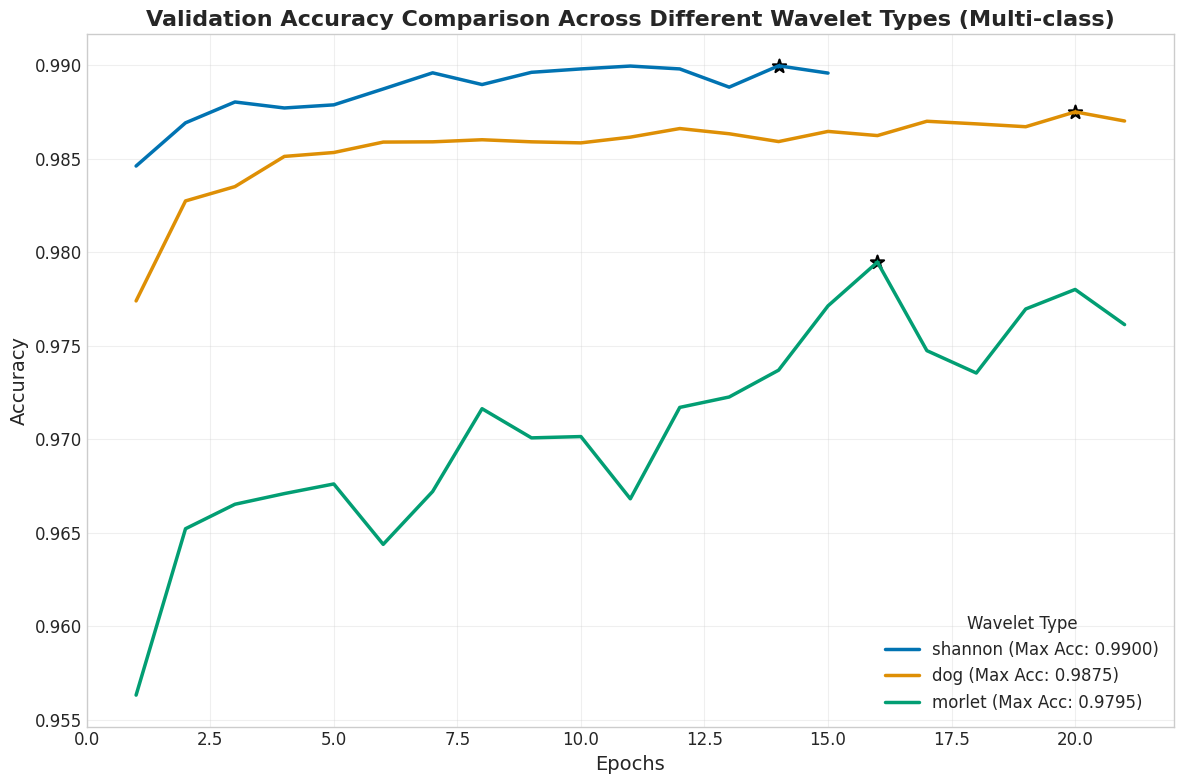

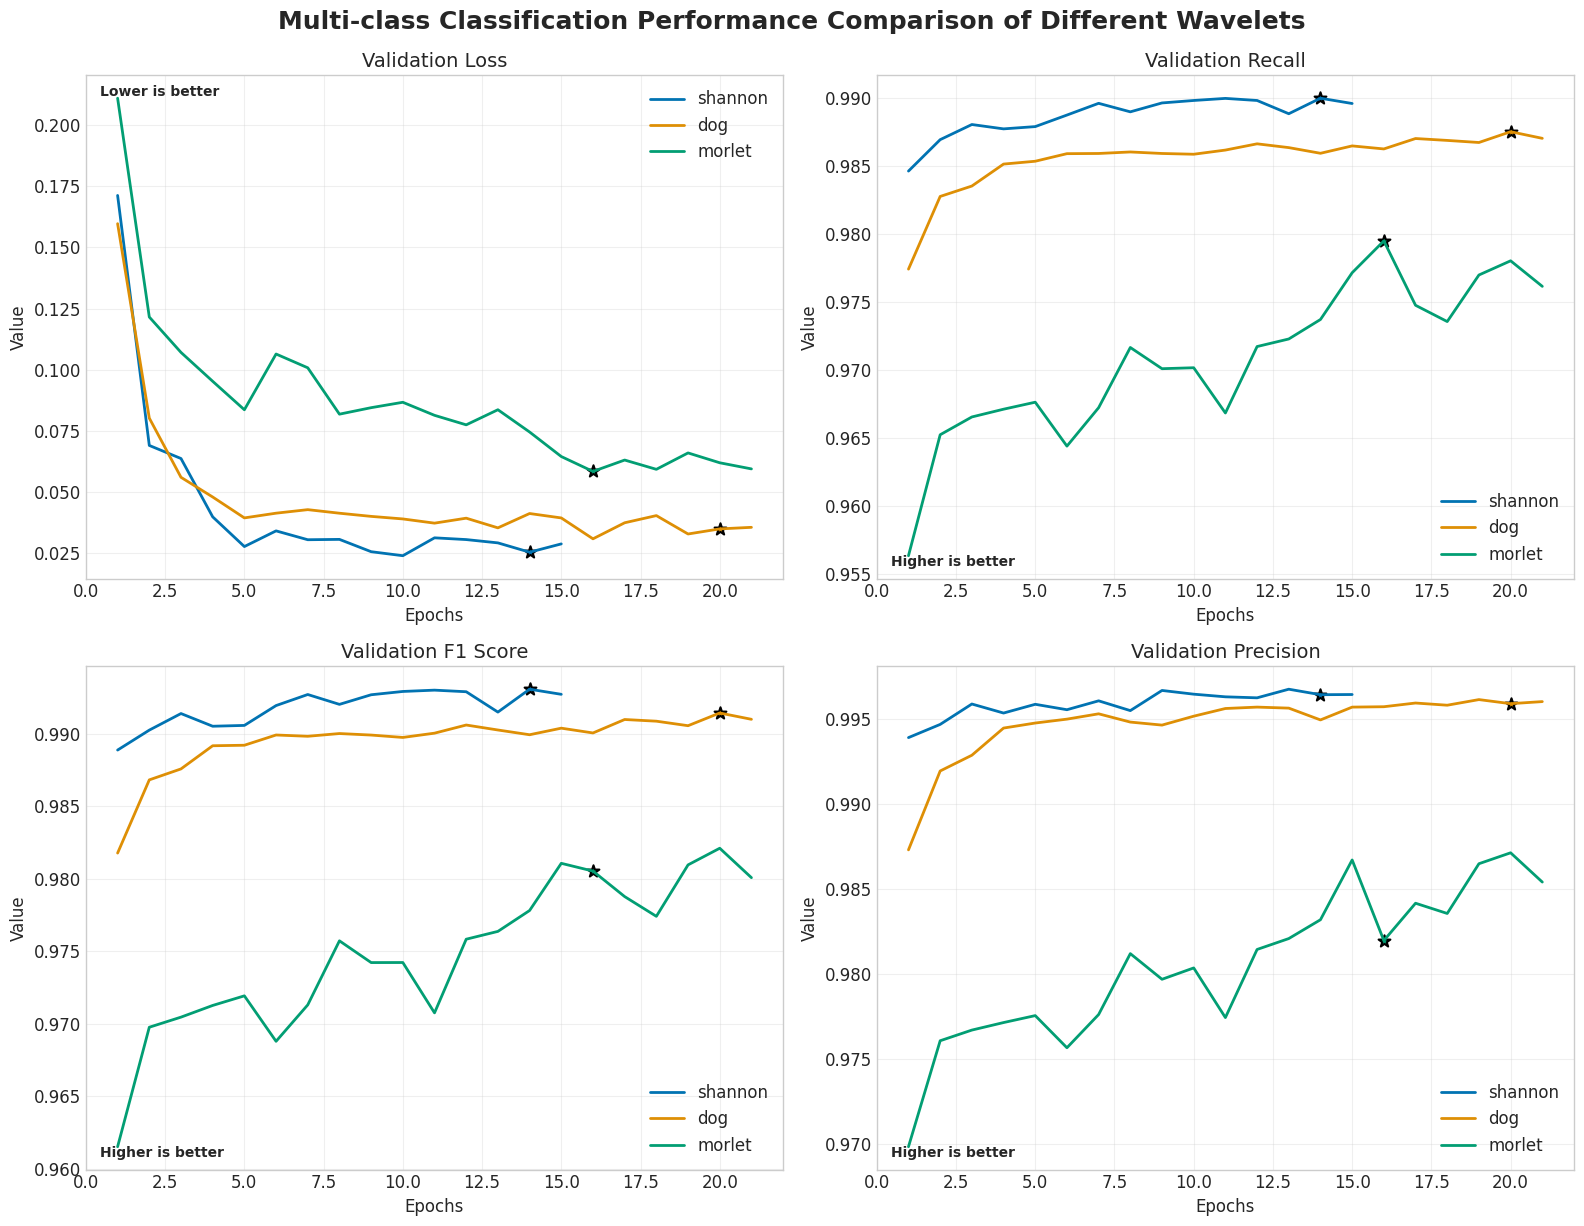


多分类模型最佳性能汇总表:


,Wavelet,Best Epoch,Val Loss,Val Accuracy,Val F1,Val Precision,Val Recall
0,shannon,14,0.0255,0.9900,N/A,N/A,N/A
1,dog,20,0.0350,0.9875,N/A,N/A,N/A
2,morlet,16,0.0585,0.9795,N/A,N/A,N/A


In [ ]:
# 为每种小波寻找验证准确率最高的epoch
best_epochs = {}
for wavelet in wavelet_types:
    if wavelet in results:
        best_epoch_idx = np.argmax(results[wavelet]['val_acc'])
        best_epochs[wavelet] = {
            'epoch': best_epoch_idx + 1,  # +1 因为索引从0开始
            'accuracy': results[wavelet]['val_acc'][best_epoch_idx]
        }

# 绘制验证准确率对比图
plt.figure(figsize=(12, 8))

# 为每种小波类型绘制线条
for wavelet in wavelet_types:
    if wavelet in results:
        epochs = range(1, len(results[wavelet]['val_acc']) + 1)
        plt.plot(epochs, results[wavelet]['val_acc'], 
                 label=f"{wavelet} (Max Acc: {best_epochs[wavelet]['accuracy']:.4f})", 
                 linewidth=2.5)
        
        # 标记最佳点
        best_epoch = best_epochs[wavelet]['epoch']
        best_acc = best_epochs[wavelet]['accuracy']
        plt.scatter(best_epoch, best_acc, s=100, marker='*', 
                   edgecolor='black', linewidth=1.5)

# 添加标题和标签
plt.title('Validation Accuracy Comparison Across Different Wavelet Types (Multi-class)', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(title='Wavelet Type', fontsize=12)
plt.grid(True, alpha=0.3)

# 保存图像
plt.tight_layout()
plt.savefig('wavelet_multiclass_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 绘制包含多个指标的对比图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 需要绘制的指标及其信息
metrics_info = [
    ('val_loss', 'Validation Loss', axes[0, 0], 'lower'),
    ('val_recall', 'Validation Recall', axes[0, 1], 'higher'),
    ('val_f1', 'Validation F1 Score', axes[1, 0], 'higher'),
    ('val_precision', 'Validation Precision', axes[1, 1], 'higher'),
    
]

# 绘制每个指标的折线图
for metric_key, title, ax, goal in metrics_info:
    for wavelet in wavelet_types:
        if wavelet in results:
            epochs = range(1, len(results[wavelet][metric_key]) + 1)
            ax.plot(epochs, results[wavelet][metric_key], 
                    label=f"{wavelet}", linewidth=2)
            
            # 标记最佳准确率对应的epoch在该指标上的值
            best_epoch = best_epochs[wavelet]['epoch']
            # 检查索引是否有效
            if 0 <= best_epoch-1 < len(results[wavelet][metric_key]):
                metric_value = results[wavelet][metric_key][best_epoch-1]
                ax.scatter(best_epoch, metric_value, s=80, marker='*', 
                          edgecolor='black', linewidth=1.5)
    
    # 设置每个子图的标题和标签
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 添加提示文本
    if goal == 'lower':
        ax.text(0.02, 0.98, "Lower is better", transform=ax.transAxes, 
                verticalalignment='top', fontsize=10, fontweight='bold')
    else:
        ax.text(0.02, 0.02, "Higher is better", transform=ax.transAxes, 
                verticalalignment='bottom', fontsize=10, fontweight='bold')

# 调整布局并添加总标题
plt.tight_layout()
fig.suptitle("Multi-class Classification Performance Comparison of Different Wavelets", 
             fontsize=18, fontweight='bold', y=1.02)

# 保存完整的多指标对比图
plt.savefig('wavelet_multiclass_comparison_all_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 创建最佳性能汇总表
comparison_data = []
for wavelet in wavelet_types:
    if wavelet in results:
        best_epoch = best_epochs[wavelet]['epoch']
        idx = best_epoch - 1  # 索引从0开始
        
        # 检查索引是否有效
        if idx < len(results[wavelet]['val_acc']):
            comparison_data.append({
                'Wavelet': wavelet,
                'Best Epoch': best_epoch,
                'Val Loss': f"{results[wavelet]['val_loss'][idx]:.4f}",
                'Val Accuracy': f"{results[wavelet]['val_acc'][idx]:.4f}",
                'Val F1': f"{results[wavelet]['val_f1'][idx]:.4f}" if 'val_macro_f1' in results[wavelet] else "N/A",
                'Val Precision': f"{results[wavelet]['val_precision'][idx]:.4f}" if 'val_macro_precision' in results[wavelet] else "N/A",
                'Val Recall': f"{results[wavelet]['val_recall'][idx]:.4f}" if 'val_macro_recall' in results[wavelet] else "N/A"
            })

# 创建DataFrame并按准确率降序排列
import pandas as pd
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Val Accuracy', ascending=False)

# 显示汇总表格
print("\n多分类模型最佳性能汇总表:")
comparison_df

In [ ]:
# Find the best performing wavelet type
best_wavelet = None
best_f1 = 0
for wavelet, metrics in results.items():
    avg_val_f1 = metrics['val_f1'][-1]  # Final epoch's F1 score
    print(f"{wavelet}: Final validation F1 = {avg_val_f1:.4f}")
    if avg_val_f1 > best_f1:
        best_f1 = avg_val_f1
        best_wavelet = wavelet

print(f"\nBest performing wavelet: {best_wavelet} with F1 score: {best_f1:.4f}")

shannon: Final validation F1 = 0.9927
dog: Final validation F1 = 0.9910
morlet: Final validation F1 = 0.9801

Best performing wavelet: shannon with F1 score: 0.9927


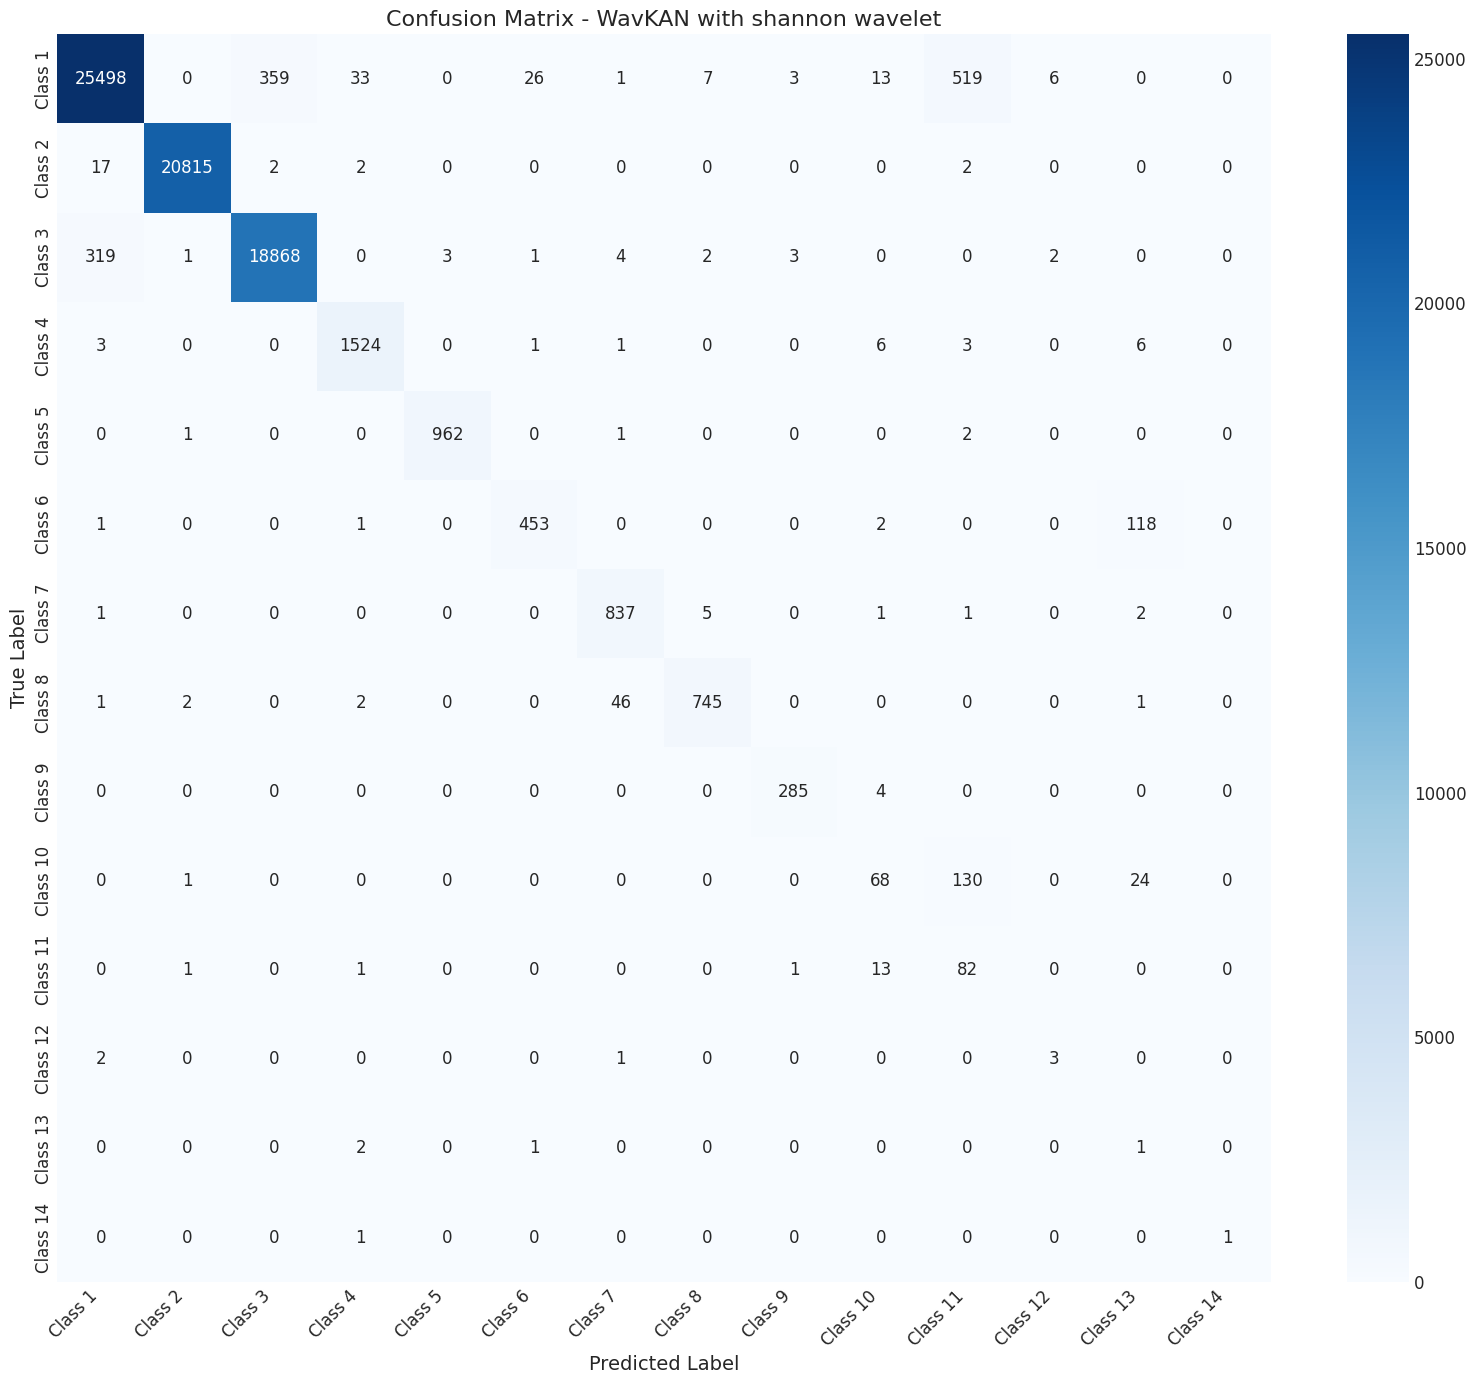


Classification Report:
              precision    recall  f1-score   support

     Class 1       0.99      0.96      0.97     26465
     Class 2       1.00      1.00      1.00     20838
     Class 3       0.98      0.98      0.98     19203
     Class 4       0.97      0.99      0.98      1544
     Class 5       1.00      1.00      1.00       966
     Class 6       0.94      0.79      0.86       575
     Class 7       0.94      0.99      0.96       847
     Class 8       0.98      0.93      0.96       797
     Class 9       0.98      0.99      0.98       289
    Class 10       0.64      0.30      0.41       223
    Class 11       0.11      0.84      0.20        98
    Class 12       0.27      0.50      0.35         6
    Class 13       0.01      0.25      0.01         4
    Class 14       1.00      0.50      0.67         2

    accuracy                           0.98     71857
   macro avg       0.77      0.79      0.74     71857
weighted avg       0.99      0.98      0.98     71857




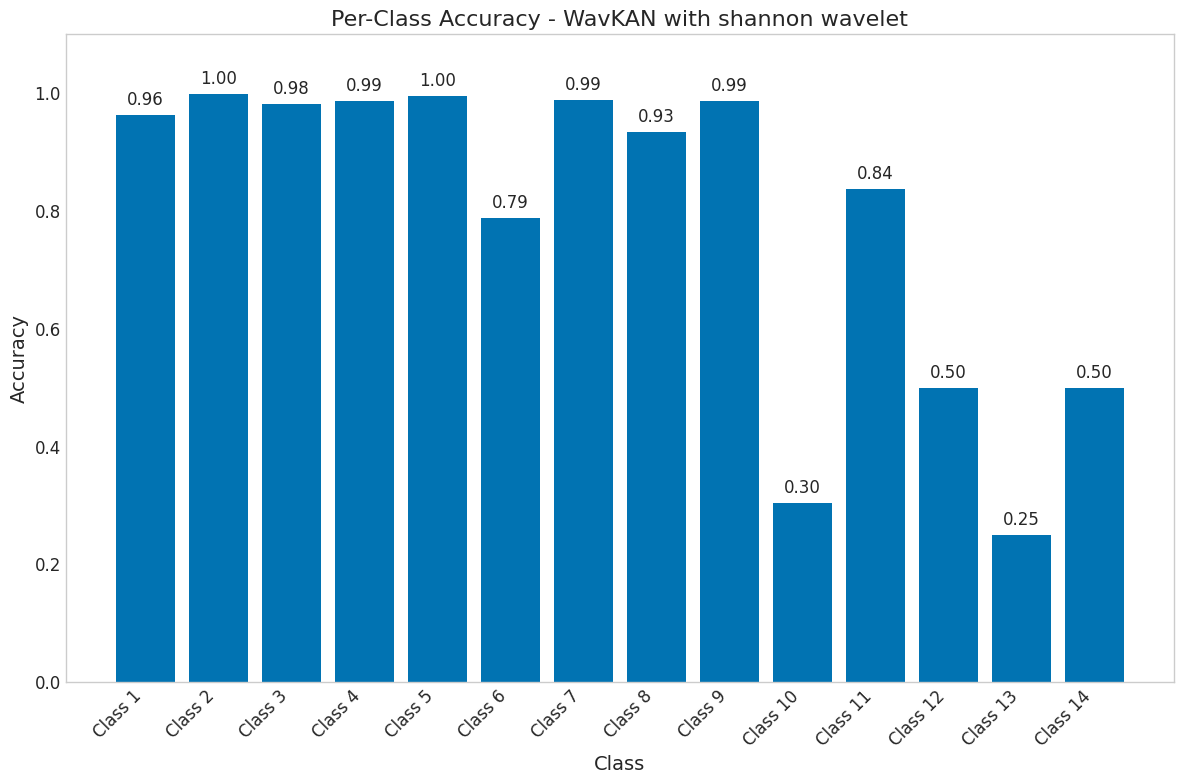

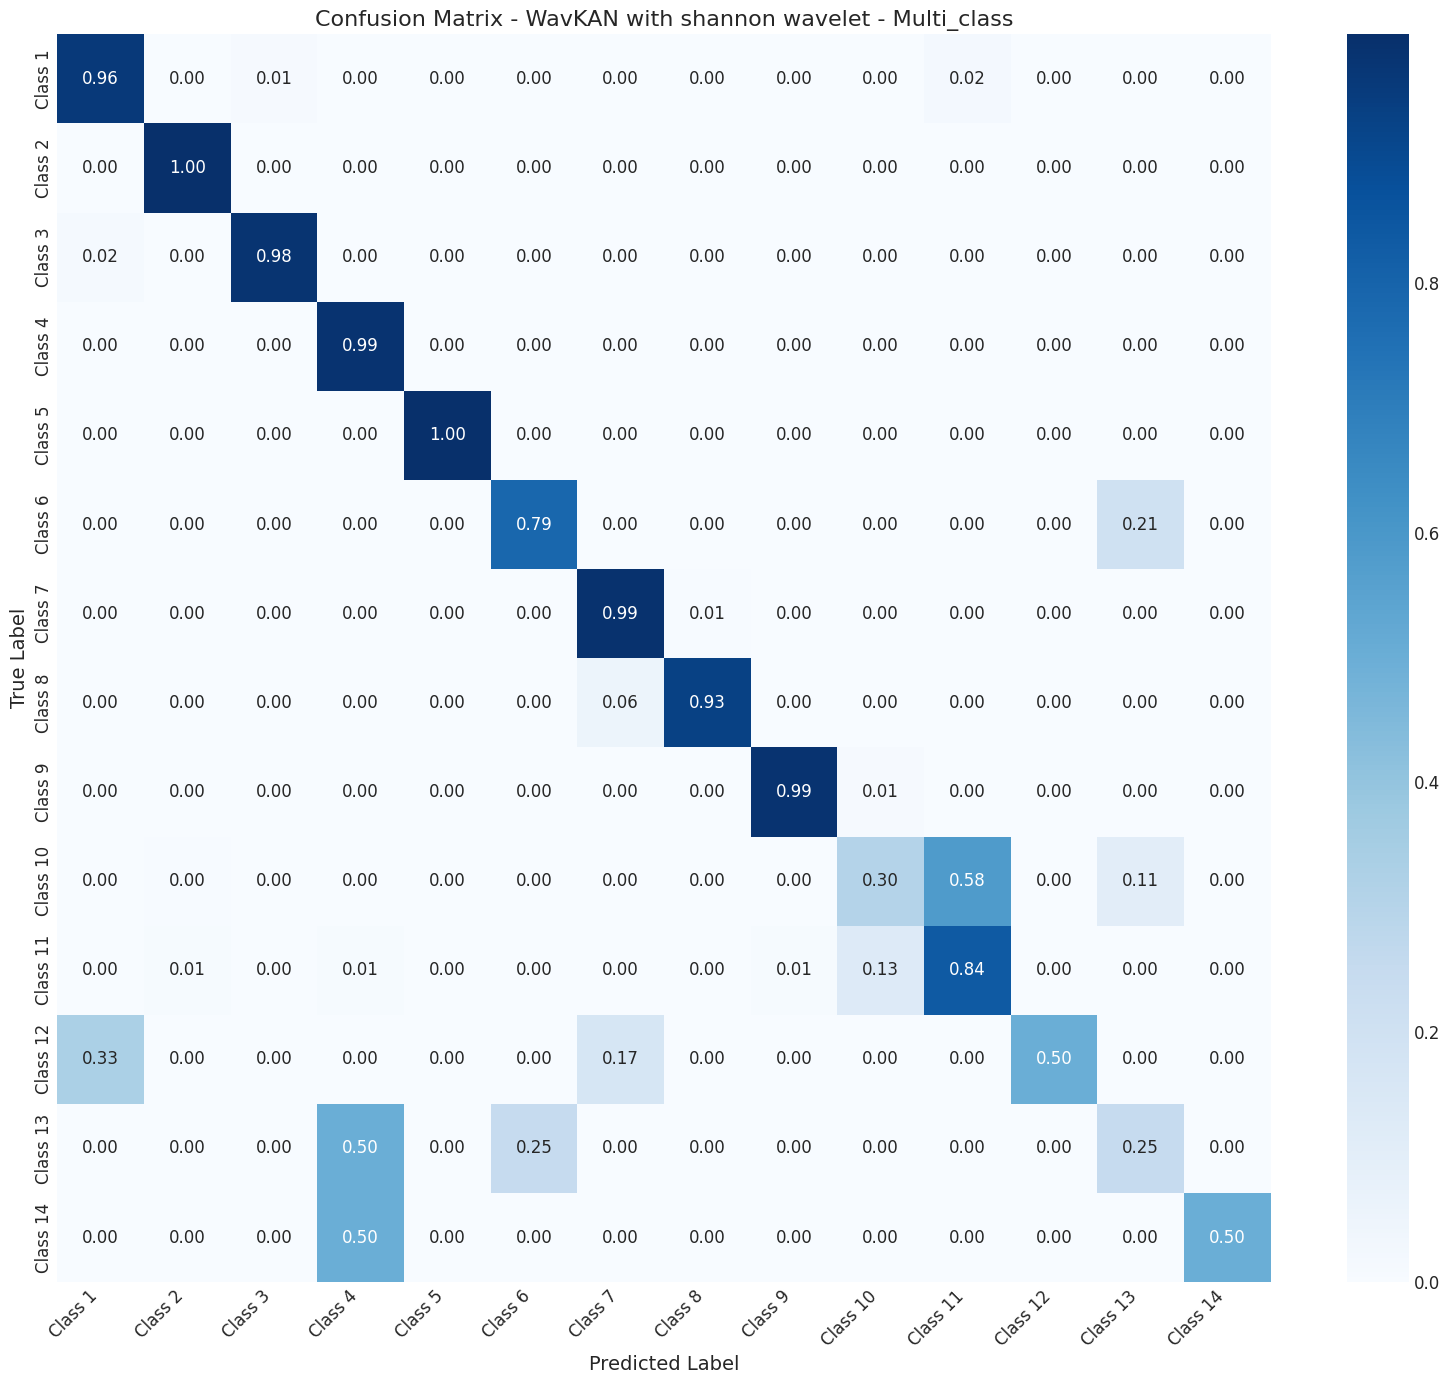

In [ ]:
# Set model to evaluation mode
model.eval()

# Generate predictions on test set
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in testloader:
        X_batch = X_batch.to(device)
        
        # Adjust labels by subtracting 1 to match model's expected range [0, num_classes-1]
        y_batch = y_batch 
        y_batch = y_batch.to(device).long()
        
        outputs = model(X_batch)
        
        # Get predicted class (no sigmoid for multiclass)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

# For reporting, add 1 back to get original class labels
all_preds_original = np.array(all_preds) + 1
all_targets_original = np.array(all_targets) + 1

# Create confusion matrix
cm = confusion_matrix(all_targets_original, all_preds_original)

# Get class labels (for multiclass)
class_labels = [f'Class {i}' for i in range(1, 15)]  # Adjust based on your class names

# Create figure with larger size for better visibility
plt.figure(figsize=(16, 14))

# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels, title, and adjust layout
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title(f'Confusion Matrix - WavKAN with {best_wavelet} wavelet', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(f'confusion_matrix_multiclass_{best_wavelet}.png', dpi=300, bbox_inches='tight')
plt.show()

# Print classification report for additional details
print("\nClassification Report:")
print(classification_report(all_targets_original, all_preds_original, 
                           target_names=class_labels, zero_division=0))

# Calculate and print additional metrics
accuracy = accuracy_score(all_targets_original, all_preds_original)
precision_micro = precision_score(all_targets_original, all_preds_original, average='micro', zero_division=0)
precision_macro = precision_score(all_targets_original, all_preds_original, average='macro', zero_division=0)
precision_weighted = precision_score(all_targets_original, all_preds_original, average='weighted', zero_division=0)

recall_micro = recall_score(all_targets_original, all_preds_original, average='micro', zero_division=0)
recall_macro = recall_score(all_targets_original, all_preds_original, average='macro', zero_division=0)
recall_weighted = recall_score(all_targets_original, all_preds_original, average='weighted', zero_division=0)

f1_micro = f1_score(all_targets_original, all_preds_original, average='micro', zero_division=0)
f1_macro = f1_score(all_targets_original, all_preds_original, average='macro', zero_division=0)
f1_weighted = f1_score(all_targets_original, all_preds_original, average='weighted', zero_division=0)

print(f"\nOverall Accuracy: {accuracy:.4f}")

print("\nPrecision:")
print(f"  Micro: {precision_micro:.4f}")
print(f"  Macro: {precision_macro:.4f}")
print(f"  Weighted: {precision_weighted:.4f}")

print("\nRecall:")
print(f"  Micro: {recall_micro:.4f}")
print(f"  Macro: {recall_macro:.4f}")
print(f"  Weighted: {recall_weighted:.4f}")

print("\nF1 Score:")
print(f"  Micro: {f1_micro:.4f}")
print(f"  Macro: {f1_macro:.4f}")
print(f"  Weighted: {f1_weighted:.4f}")

# Plot per-class accuracy
plt.figure(figsize=(12, 8))
class_accuracy = cm.diagonal() / cm.sum(axis=1)
bars = plt.bar(class_labels, class_accuracy)

# Add value labels on the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}',
             ha='center', va='bottom', rotation=0)

plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title(f'Per-Class Accuracy - WavKAN with {best_wavelet} wavelet')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.grid(False)
plt.savefig(f'per_class_accuracy_{best_wavelet}.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot normalized confusion matrix (percentage)
plt.figure(figsize=(16, 14))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title(f'Confusion Matrix - WavKAN with {best_wavelet} wavelet - Multi_class', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'normalized_confusion_matrix_{best_wavelet}.png', dpi=300, bbox_inches='tight')
plt.show()